# Tumoroscope in PyMC

## Setup

In [1]:
from dataclasses import dataclass

import arviz as az
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Introduction

![tumoroscope overview](tumoroscope-overview.png)

## Model

In [3]:
@dataclass
class TumoroscopeData:
    """Tumoroscope model data."""

    K: int  # number of clones
    S: int  # number of spots
    P: int  # number of mutation positions
    F: np.ndarray  # Prevelance of clones from bulk-DNA seq.
    Lambda: np.ndarray  # Number of cell counted per spot
    C: np.ndarray  # Zygosity per position and clone
    D_obs: np.ndarray | None  # Read count per position per spot
    A_obs: np.ndarray | None  # Alternated reads per position per spot
    zeta_s: float = 1  # Pi hyper-parameter
    F_0: float = 0.01  # "pseudo-frequency" for lower bound on clone proportion
    l: float = 100  # Scaling factor to discretize F
    r: float = 0.09  # shape parameter for Gamma over Phi
    p: float = 1  # rate parameter for Gamma over Phi


def _prefixed_index(n: int, prefix: str) -> list[str]:
    return [f"{prefix}{i}" for i in np.arange(n)]


def _check_tumoroscope_data(data: TumoroscopeData) -> None:
    assert data.F.sum() == 1.0
    assert data.F.ndim == 1
    assert data.F.shape[0] == data.K


def _make_tumoroscope_model_coords(data: TumoroscopeData) -> dict[str, list[str]]:
    coords = {
        "clone": _prefixed_index(data.K, "c"),
        "spot": _prefixed_index(data.S, "s"),
        "position": _prefixed_index(data.P, "p"),
    }
    return coords


def tumoroscope(data: TumoroscopeData) -> pm.Model:
    _check_tumoroscope_data(data)
    coords = _make_tumoroscope_model_coords(data)
    with pm.Model(coords=coords) as model:
        ζ_s = pm.ConstantData("ζ_s", data.zeta_s)
        ℓ = pm.ConstantData("ℓ", data.l)
        F_0 = pm.ConstantData("F0", data.F_0)
        F = pm.ConstantData("F", data.F)
        Λ = pm.ConstantData("Λ", data.Lambda, dims="spot")
        r = pm.ConstantData("r", data.r)
        p = pm.ConstantData("p", data.p)
        C = pm.ConstantData("C", data.C, dims=("position", "clone"))

        F_prime = pm.Deterministic("F_prime", ℓ * 20 * F / 20)

        Π = pm.Beta("Π", alpha=ζ_s / data.K, beta=1, dims=("spot", "clone"))
        Z = pm.Bernoulli("Z", p=Π, dims=("spot", "clone"))
        G = pm.Gamma("G", F_prime**Z * F_0 ** (1 - Z), 1, dims=("spot", "clone"))
        H = pm.Deterministic("H", G / G.sum(axis=1)[:, None], dims=("spot", "clone"))

        N = pm.Poisson("N", Λ, dims="spot")
        Φ = pm.Gamma("Φ", r, p, dims=("position", "clone"))
        D = pm.Poisson(
            "D", N * H.dot(Φ.T).T, dims=("position", "spot"), observed=data.D_obs
        )

        _A_num = pm.Deterministic("A_num", H[:, 1:].dot((Φ[:, 1:] * C[:, 1:]).T).T)
        _A_denom = pm.Deterministic("A_denom", H[:, 1:].dot(Φ[:, 1:].T).T)
        A = pm.Binomial(
            "A", D, _A_num / _A_denom, dims=("position", "spot"), observed=data.A_obs
        )
    return model

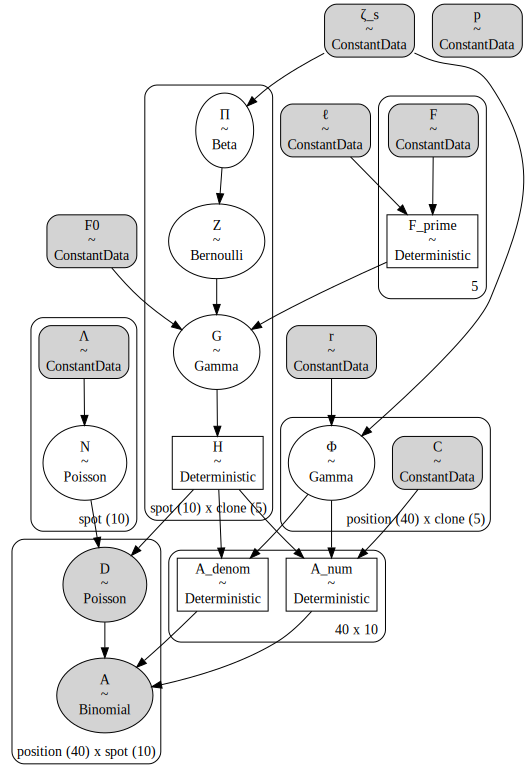

In [4]:
np.random.seed(234)
mock_tumor_data = TumoroscopeData(
    K=5,
    S=10,
    P=40,
    F=np.ones(5) / 5.0,
    Lambda=np.random.randint(1, 20, size=10),
    C=np.random.beta(2, 2, size=(40, 5)),
    D_obs=np.random.randint(2, 20, size=(40, 10)),
    A_obs=np.random.randint(2, 20, size=(40, 10)),
)

m = tumoroscope(mock_tumor_data)
pm.model_to_graphviz(m)

To-Do:

- generate mock data and test model
- try to use Dirichlet for $P(H|F^\prime,F_0,Z)$ like the Methods explains

Possible improvements

- explore prior distributions over the current user-supplied hyper-parameters
- utilize spatial relationships in the estimation of clonal distributions per spot

## Prior predictive sampling

In [5]:
example_input_data = TumoroscopeData(
    K=5,
    S=10,
    P=40,
    F=np.array([0.01, 0.05, 0.15, 0.3, 0.49]),
    Lambda=np.ones(10) * 5,
    C=np.ones((40, 5), float),
    D_obs=None,
    A_obs=None,
    r=0.19,
    p=1,
)

with tumoroscope(example_input_data) as m:
    prior_pred = pm.sample_prior_predictive(
        500,
        var_names=["D", "A", "H", "G", "Z", "Π", "Φ", "N", "A_num", "A_denom"],
        random_seed=123,
    )

Sampling: [A, D, G, N, Z, Π, Φ]


In [6]:
prior_pred.constant_data["Λ"].values

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

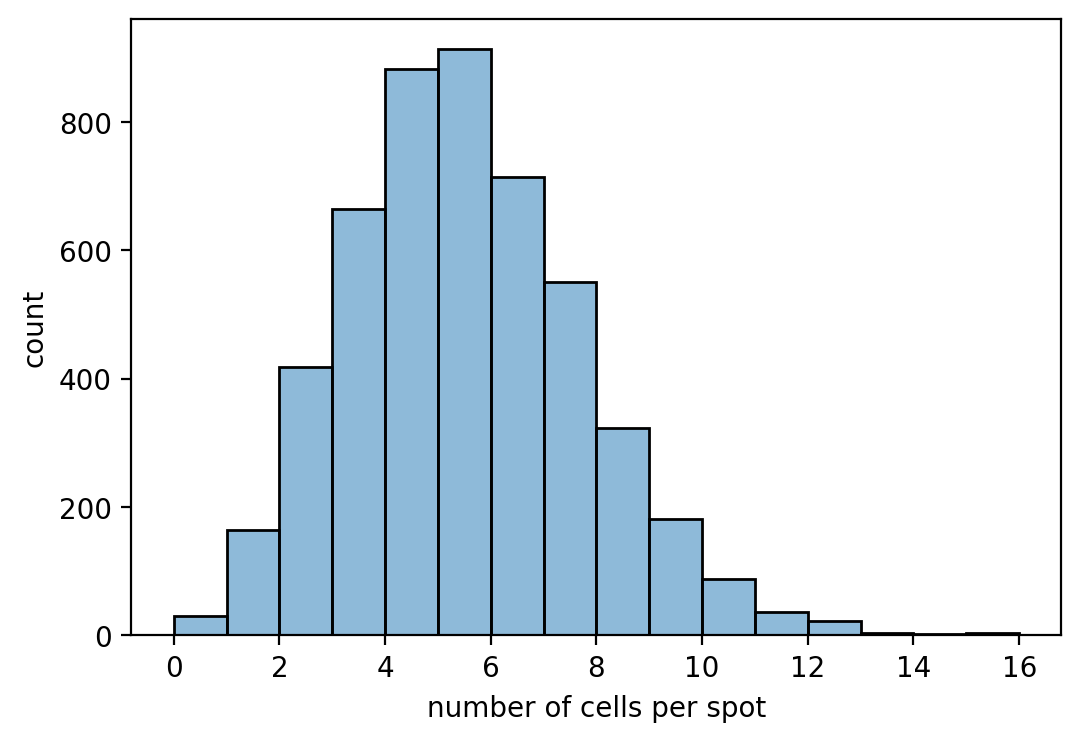

In [7]:
_, ax = plt.subplots(figsize=(6, 4))
sns.histplot(prior_pred.prior["N"].values.flatten(), alpha=0.5, binwidth=1, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

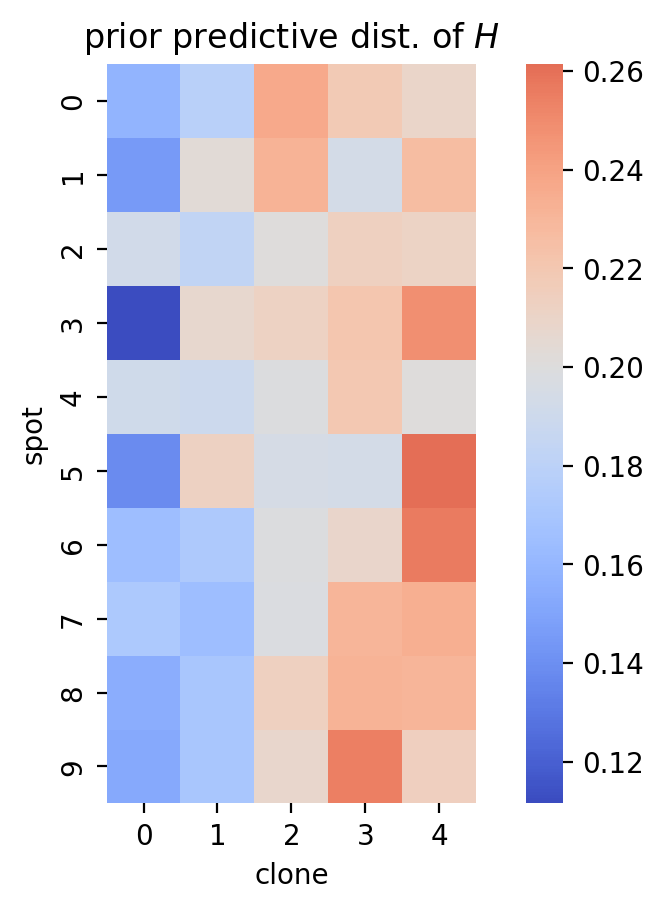

In [8]:
H_mean = prior_pred.prior["H"].values.squeeze().mean(axis=0)
ax = sns.heatmap(
    data=H_mean, cmap="coolwarm", center=1 / mock_tumor_data.K, square=True
)
ax.set_xlabel("clone")
ax.set_ylabel("spot")
ax.set_title("prior predictive dist. of $H$")
plt.show()

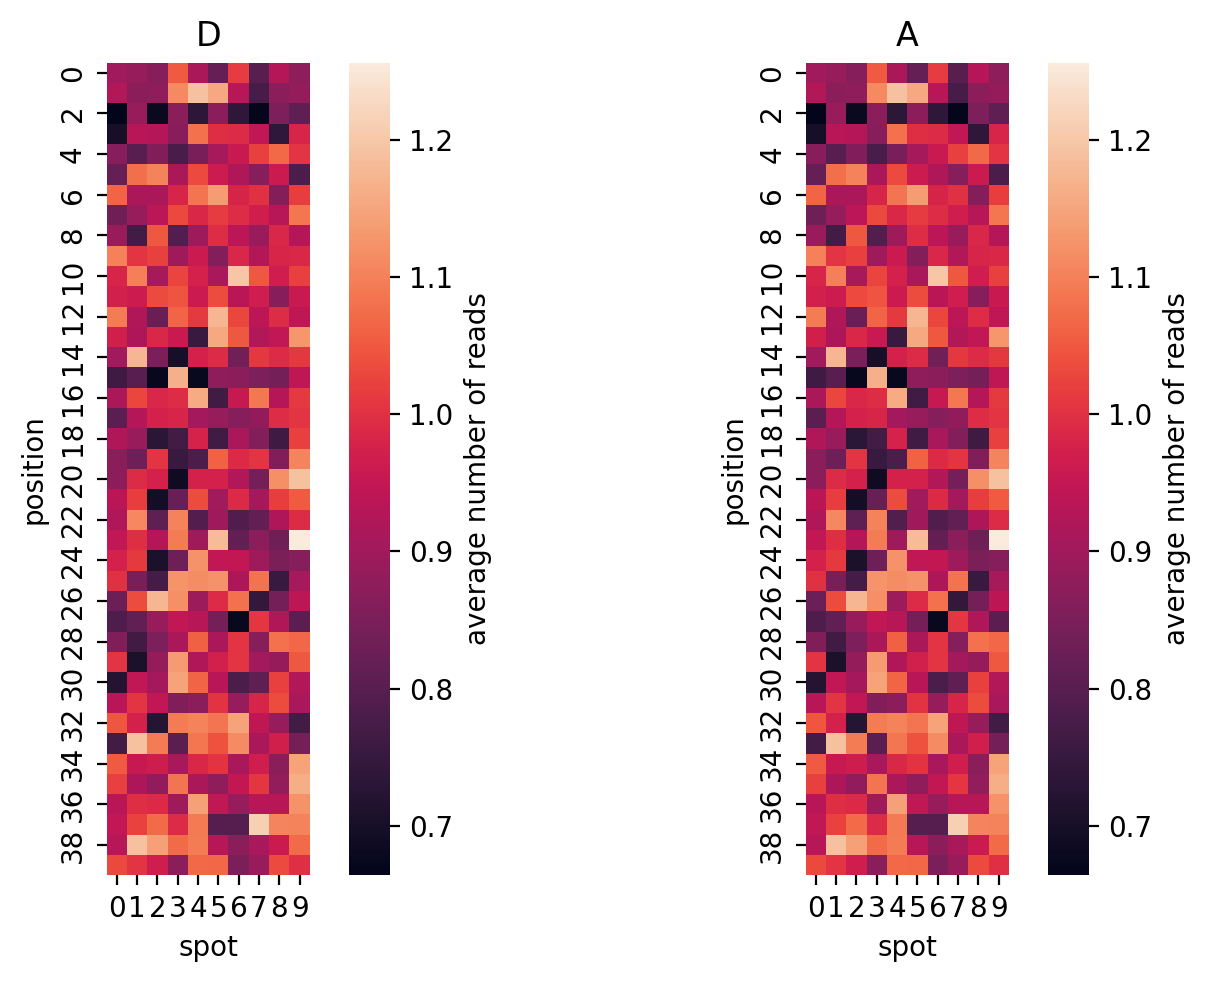

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
for ax, var_name in zip(axes, ["D", "A"]):
    var_prior_mean = prior_pred.prior[var_name].mean(axis=(0, 1)).values
    sns.heatmap(
        var_prior_mean,
        square=True,
        cbar_kws={"label": "average number of reads"},
        ax=ax,
    )
    ax.set_xlabel("spot")
    ax.set_ylabel("position")
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

Average number of reads *per spot*.

In [10]:
prior_pred.prior["D"].mean(axis=(0, 1)).sum(axis=0).values

array([36.448, 38.086, 36.56 , 38.236, 39.044, 38.76 , 37.422, 36.94 ,
       37.214, 39.668])

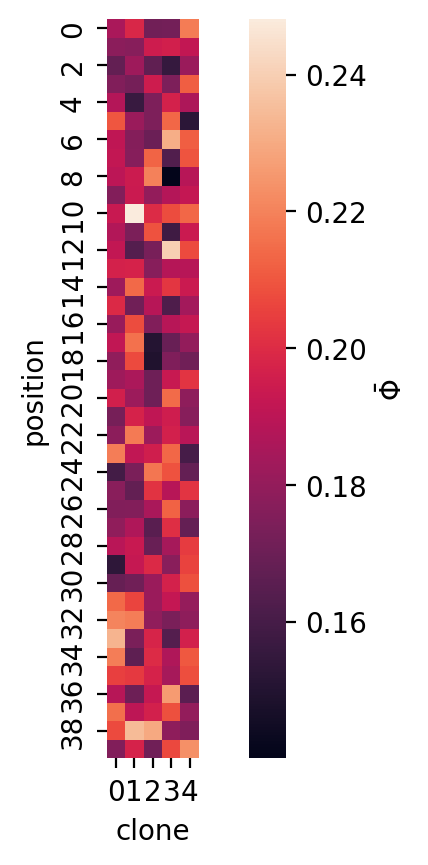

In [11]:
phi_prior_mean = prior_pred.prior["Φ"].mean(axis=(0, 1)).values
ax = sns.heatmap(phi_prior_mean, square=True, cbar_kws={"label": r"$\bar{\Phi}$"})
ax.set_xlabel("clone")
ax.set_ylabel("position")
plt.show()

## Simulation experiments

In [13]:
# Set seed for reproducible results.
np.random.seed(8383)

# Set true underlying constants.
N_CLONES = 5
N_SPOTS = 20
n_positions = 300  # changes below

# Number of cells counted in each spot between 2 and 8 cells.
cell_counts = np.random.randint(2, 8, size=N_SPOTS)

# True mutations for each clone.
clone_mutations = np.hstack(
    [
        np.random.binomial(1, p, size=(n_positions, 1))
        for p in [0.05, 0.1, 0.2, 0.3, 0.4]
    ]
)
# Drop positions without any mutations.
clone_mutations = clone_mutations[clone_mutations.sum(axis=1) > 0, :]
n_positions = clone_mutations.shape[0]
print(f"Number of positions: {n_positions}")

# Assign probability distribution over spots for each clone.
clone_props_params = [(2, 2), (1, 3), (4, 2), (5, 5), (1, 1)]
spots_x = np.linspace(0, 1, N_SPOTS)
clone_proportions = np.hstack(
    [scipy.stats.beta(a, b).pdf(spots_x)[:, None] for a, b in clone_props_params]
)
clone_proportions = clone_proportions / clone_proportions.sum(axis=1)[:, None]

# True fraction of clones taken from the underlying distributions.
F = np.array([a / (a + b) for a, b in clone_props_params])
F = F / F.sum()

_cell_labels: list[tuple[int, int, int]] = []
clones = np.arange(N_CLONES)
for spot_i in range(N_SPOTS):
    for cell_j in range(cell_counts[spot_i]):
        clone = np.random.choice(clones, size=1, p=clone_proportions[spot_i, :])[0]
        _cell_labels.append((spot_i, cell_j, clone))
cell_labels = pd.DataFrame(_cell_labels, columns=["spot", "cell", "clone"])
cell_labels.head()

Number of positions: 214


,spot,cell,clone
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,1,0,4


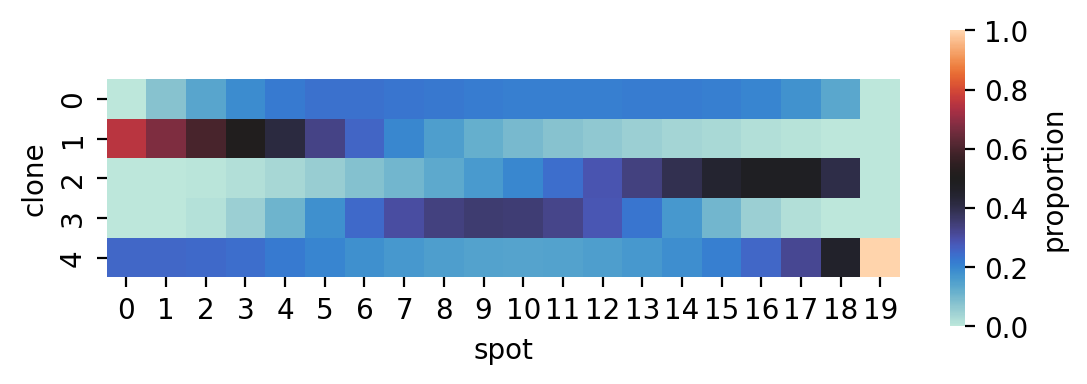

In [14]:
ax = sns.heatmap(
    clone_proportions.T,
    cmap="icefire",
    center=0.5,
    vmin=0,
    vmax=1.0,
    square=True,
    cbar_kws={"shrink": 0.4, "label": "proportion"},
)
ax.set_xlabel("spot")
ax.set_ylabel("clone")
plt.show()

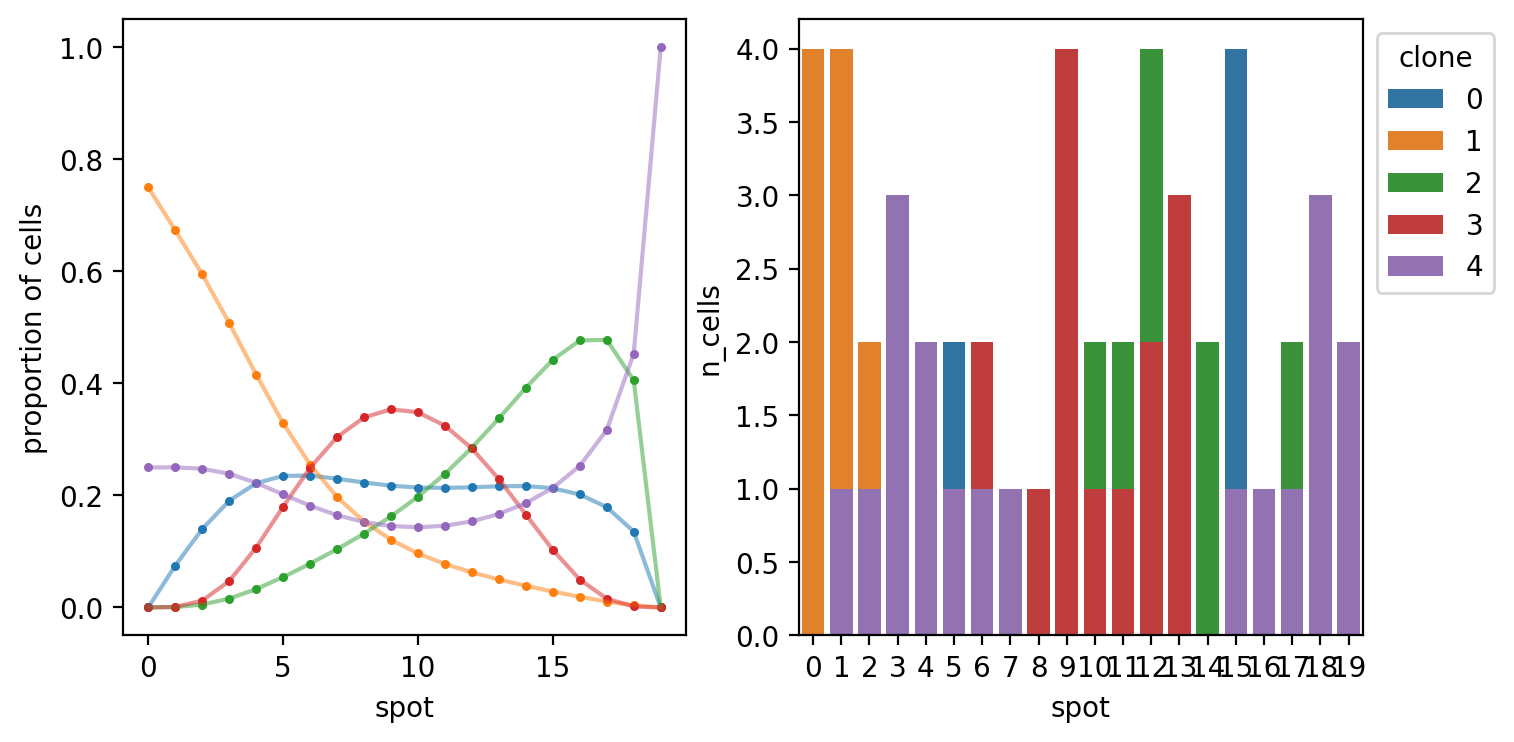

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

ax = axes[0]
for i in range(clone_proportions.shape[1]):
    x = np.arange(clone_proportions.shape[0])
    ax.plot(x, clone_proportions[:, i], label=f"{i}", alpha=0.5)
    ax.scatter(x, clone_proportions[:, i], s=5)

ax.set_xlabel("spot")
ax.set_ylabel("proportion of cells")

ax = axes[1]
clones_per_spot = (
    cell_labels.groupby(["spot", "clone"])
    .count()
    .reset_index()
    .rename(columns={"cell": "n_cells"})
    .astype({"clone": "category"})
)

sns.barplot(
    data=clones_per_spot, x="spot", y="n_cells", hue="clone", ax=ax, dodge=False
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), title="clone")
plt.show()

Actual clone proportions vs. the randomly sampled clone proportions averaging across spots:

In [16]:
F, clone_proportions.mean(axis=0)

(array([0.20689655, 0.10344828, 0.27586207, 0.20689655, 0.20689655]),
 array([0.17863275, 0.21921696, 0.19198066, 0.15578497, 0.25438466]))

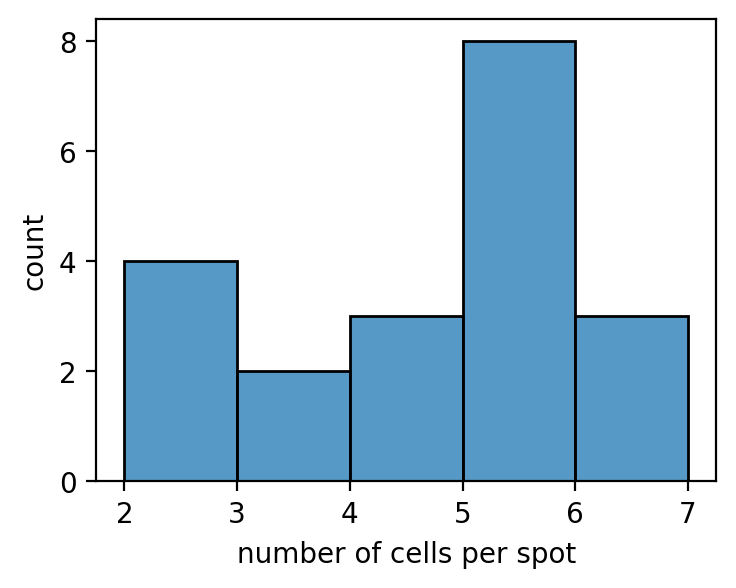

In [17]:
_, ax = plt.subplots(figsize=(4, 3))
sns.histplot(cell_counts.flatten(), binwidth=1, ax=ax)
ax.set_xlabel("number of cells per spot")
ax.set_ylabel("count")
plt.show()

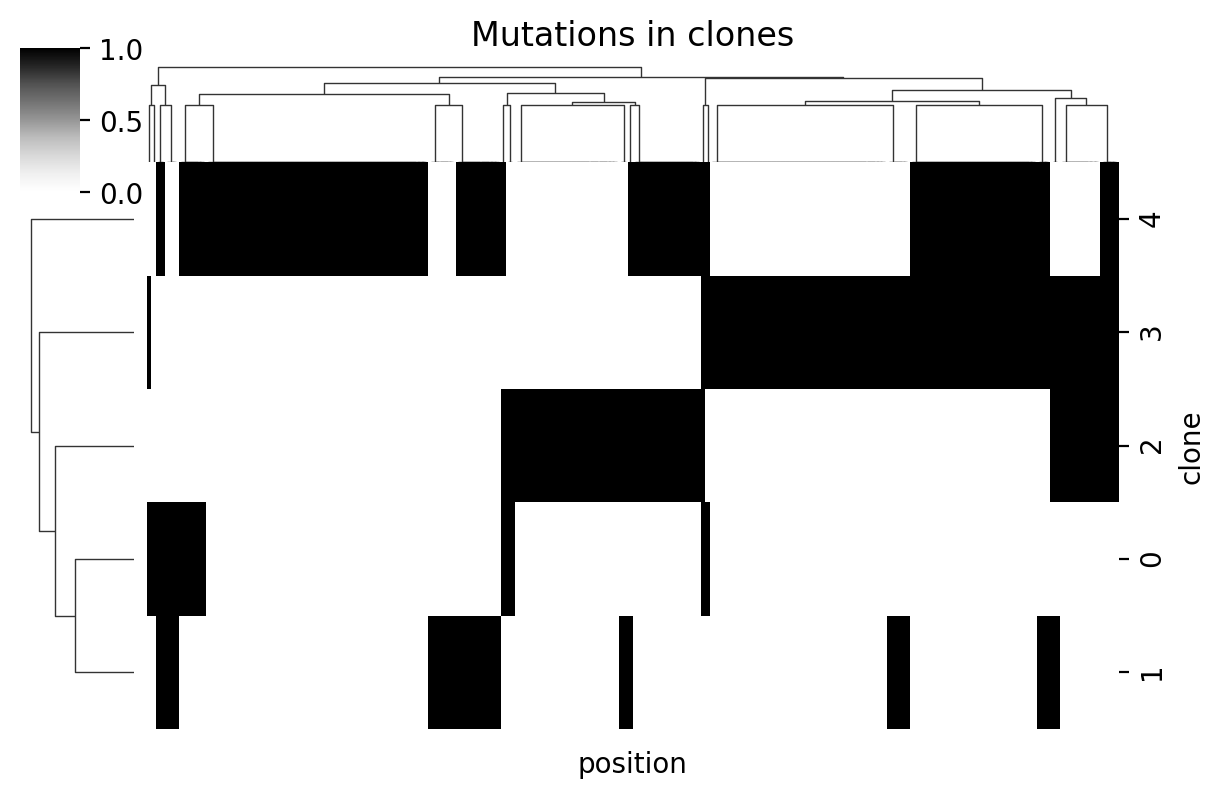

In [18]:
cg = sns.clustermap(
    clone_mutations.T, figsize=(6, 4), dendrogram_ratio=(0.1, 0.15), cmap="Greys"
)
cg.ax_heatmap.set_xlabel("position")
cg.ax_heatmap.set_ylabel("clone")
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.tick_params("x", size=0)
cg.ax_col_dendrogram.set_title("Mutations in clones")
plt.show()

In [19]:
clone_mutations.shape

(214, 5)

In [20]:
# Randomly assign read coverage per position per spot with min of 2 reads.
# read_coverage = np.random.poisson(10, size=(n_positions, N_SPOTS)) + 2

# Randomly assign zygosity per position for each clone.
zygosity = np.random.beta(10, 1, size=(n_positions, N_CLONES))
print(f"average zygosity: {zygosity.mean():0.2f}")

# For each cell in each spot, sample some number of reads for each position.
# Builds the matrix A for number of alternate reads per position and spot.
# alt_read_counts = (clone_mutations * zygosity).dot(clone_proportions.T) * read_coverage
alt_read_counts = np.zeros((n_positions, N_SPOTS, N_CLONES))
tot_read_counts = np.zeros((n_positions, N_SPOTS, N_CLONES))
for _, row in cell_labels.iterrows():
    alt_reads = (
        np.random.poisson(3, size=n_positions) * clone_mutations[:, row["clone"]]
    )
    alt_read_counts[:, row["spot"], row["clone"]] = alt_reads
    tot_reads = alt_reads + (1 - zygosity[:, row["clone"]]) * alt_reads
    tot_read_counts[:, row["spot"], row["clone"]] = tot_reads

alt_read_counts = alt_read_counts.sum(axis=2)
tot_read_counts = tot_read_counts.sum(axis=2)
alt_read_counts.shape

average zygosity: 0.91


(214, 20)

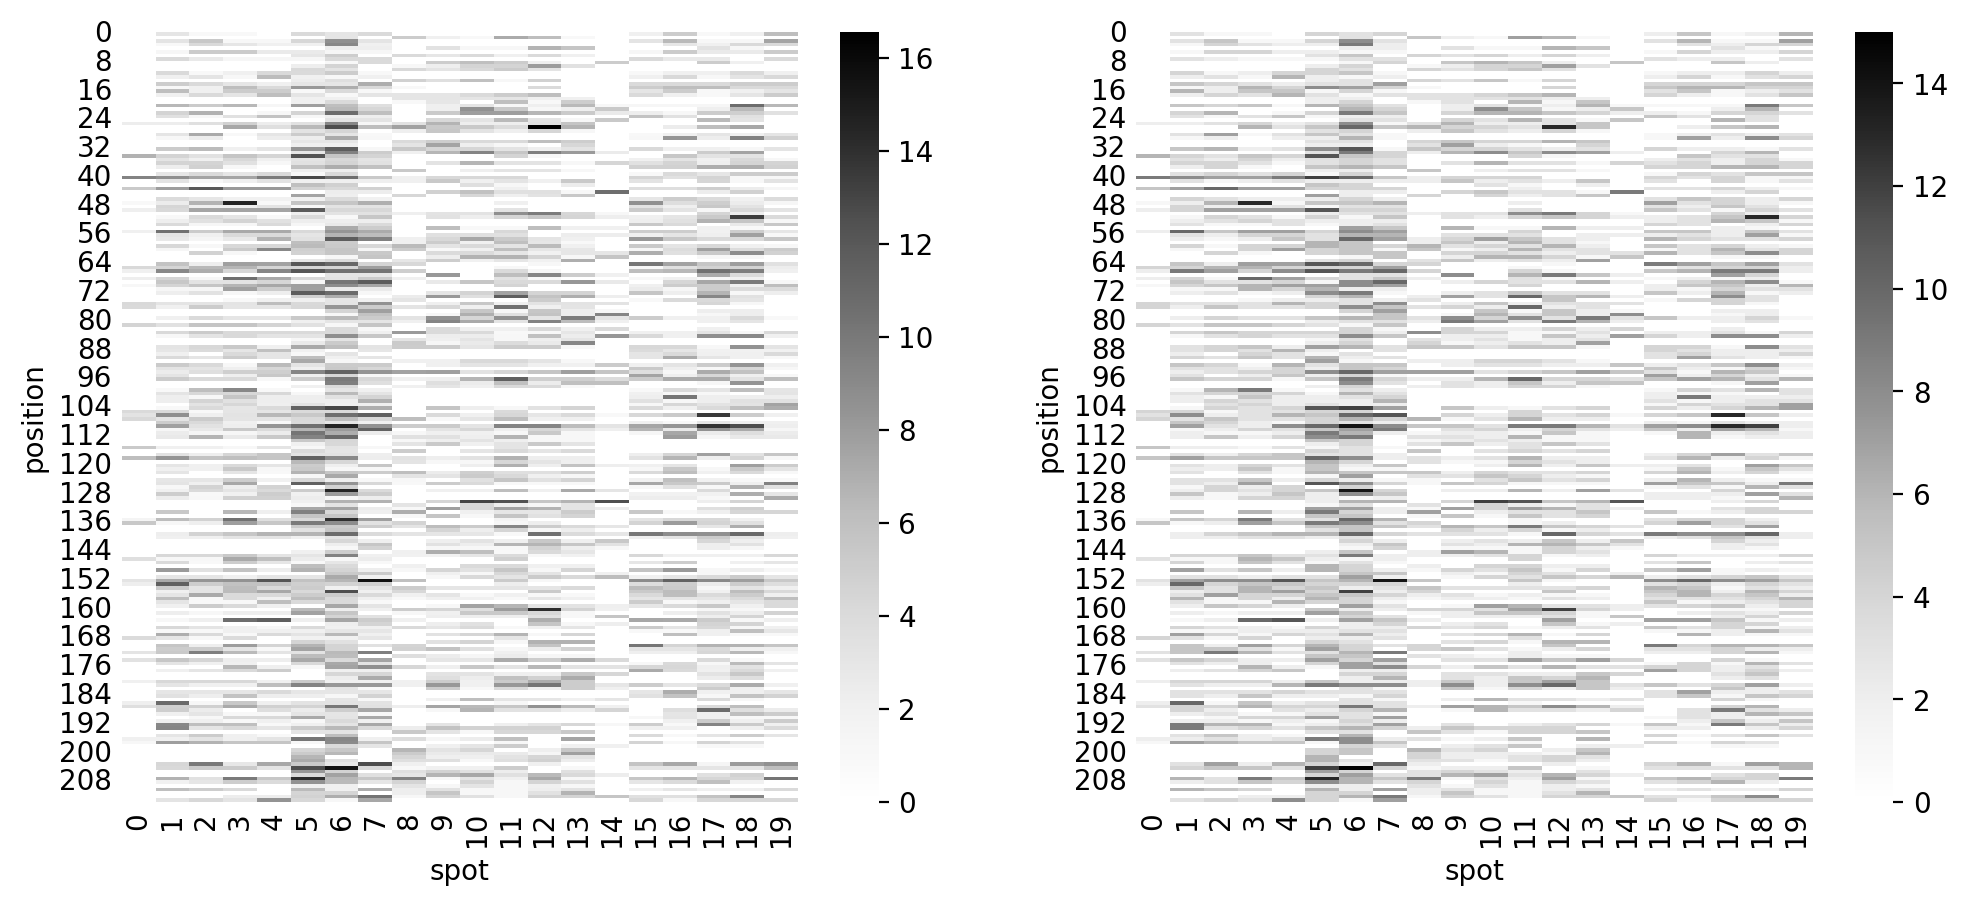

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
sns.heatmap(tot_read_counts, cmap="Greys", ax=axes[0])
ax.set_title("Total read counts")
sns.heatmap(alt_read_counts, cmap="Greys", ax=axes[1])
ax.set_title("Alternative read counts")

for ax in axes:
    ax.tick_params(size=0)
    ax.set_xlabel("spot")
    ax.set_ylabel("position")

plt.show()

Number of reads per spot.

In [22]:
tot_read_counts.sum(axis=0).round(2)

array([ 111.96,  529.77,  493.38,  597.82,  543.63,  874.65, 1103.24,
        710.84,  342.02,  470.99,  492.39,  615.41,  580.12,  484.67,
        212.66,  446.87,  511.95,  599.54,  659.08,  405.28])

In [23]:
sim_data = TumoroscopeData(
    K=N_CLONES,
    S=N_SPOTS,
    P=n_positions,
    F=F,
    Lambda=cell_counts,
    C=zygosity,
    D_obs=tot_read_counts,
    A_obs=alt_read_counts,
    zeta_s=N_CLONES,
)

with tumoroscope(mock_tumor_data):
    sim_trace = pm.sample(draws=500, tune=500, chains=2, cores=2, random_seed=10)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Π_logodds__': array([[-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791],
       [-1.60943791, -1.60943791, -1.60943791, -1.60943791, -1.60943791]]), 'Z': array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]]), 'G_log__': array([[-4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],
       [-4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],
       [-4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],
       [-4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],
       [-4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],
       [-4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],
       [-4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],
       [-4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],
       [-4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],
       [-4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019]]), 'N': array([ 9,  5,  2,  4,  8, 17,  4,  3,  9,  8]), 'Φ_log__': array([[-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561],
       [-2.40794561, -2.40794561, -2.40794561, -2.40794561, -2.40794561]])}

Initial evaluation results:
{'Π': -107.51, 'Z': -9.12, 'G': -232.78, 'N': -18.14, 'Φ': -533.82, 'D': -10410.26, 'A': -inf}

---

## Session information

In [24]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-10-07

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: jhcookmac.harvardsecure.wireless.med.harvard.edu

Git branch: tumoroscope

seaborn   : 0.12.0
scipy     : 1.9.1
arviz     : 0.12.1
matplotlib: 3.6.0
numpy     : 1.23.3
janitor   : 0.22.0
pymc      : 4.2.1
pandas    : 1.5.0

